# Log Analysis 

In [69]:
import os
import json # To read a JSON Log file
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Opening the Logs

For the purpose of this project, we will be performing only 3 types of Logs (similar to what we did on Zui)

### Connections

In [70]:
conn_log = './zeek-logs/conn.log'

with open(conn_log, "r", encoding="utf-8") as f:
    fields = None
    for line in f:
        if line.startswith("#fields"):
            fields = line.strip().split("\t")[1:]
            break

df_conn = pd.read_csv(conn_log, sep="\t", comment="#", header=None, names=fields, engine="python")
df_conn.head(5)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
0,1.737575e+09,CP5Not1NC0vL0NrFq,10.1.17.215,50084,10.1.17.2,389,tcp,ldap_tcp,0.003811,2229,...,RSTR,T,T,0,ShADadrF,6,2481,4,382,-
1,1.737575e+09,C3m4xCxAjFQ0PE9Jc,10.1.17.215,50087,23.220.102.9,80,tcp,http,0.096900,111,...,SF,T,F,0,ShADadfF,5,323,5,399,-
2,1.737575e+09,CjW92u35kInN73NYQf,10.1.17.215,50086,52.156.123.84,443,tcp,ssl,0.497973,673,...,SF,T,F,0,ShADdaFfR,13,1205,10,3620,-
3,1.737575e+09,COMfpR2ZojwhF6Jz1b,10.1.17.215,57386,10.1.17.2,53,udp,dns,0.000358,89,...,SF,T,T,0,Dd,1,117,1,188,-
4,1.737575e+09,CaKrEw4VwHXNpq8uu5,10.1.17.215,56330,224.0.0.252,5355,udp,dns,0.409832,66,...,S0,T,F,0,D,2,122,0,0,-


In [71]:
# Converting the ts column
print(df_conn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ts              859 non-null    float64
 1   uid             859 non-null    object 
 2   id.orig_h       859 non-null    object 
 3   id.orig_p       859 non-null    int64  
 4   id.resp_h       859 non-null    object 
 5   id.resp_p       859 non-null    int64  
 6   proto           859 non-null    object 
 7   service         859 non-null    object 
 8   duration        859 non-null    object 
 9   orig_bytes      859 non-null    object 
 10  resp_bytes      859 non-null    object 
 11  conn_state      859 non-null    object 
 12  local_orig      859 non-null    object 
 13  local_resp      859 non-null    object 
 14  missed_bytes    859 non-null    int64  
 15  history         859 non-null    object 
 16  orig_pkts       859 non-null    int64  
 17  orig_ip_bytes   859 non-null    int

In [72]:
df_conn['ts_dt'] = pd.to_datetime(df_conn['ts'], unit='s', utc=True)
df_conn.head(2)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ts_dt
0,1.737575e+09,CP5Not1NC0vL0NrFq,10.1.17.215,50084,10.1.17.2,389,tcp,ldap_tcp,0.003811,2229,...,T,T,0,ShADadrF,6,2481,4,382,-,2025-01-22 19:44:56.656842947+00:00
1,1.737575e+09,C3m4xCxAjFQ0PE9Jc,10.1.17.215,50087,23.220.102.9,80,tcp,http,0.096900,111,...,T,F,0,ShADadfF,5,323,5,399,-,2025-01-22 19:45:01.364100933+00:00


### HTTP

In [73]:
http_log = './zeek-logs/http.log'

with open(http_log, "r", encoding="utf-8") as f:
    fields = None
    for line in f:
        if line.startswith("#fields"):
            fields = line.strip().split("\t")[1:]
            break

df_http = pd.read_csv(http_log, sep="\t", comment="#", header=None, names=fields, engine="python")
df_http.head(5)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,...,tags,username,password,proxied,orig_fuids,orig_filenames,orig_mime_types,resp_fuids,resp_filenames,resp_mime_types
0,1.737575e+09,C3m4xCxAjFQ0PE9Jc,10.1.17.215,50087,23.220.102.9,80,1,GET,www.msftconnecttest.com,/connecttest.txt,...,(empty),-,-,-,-,-,-,FxGwXt1O50zSlanzXb,-,text/plain
1,1.737575e+09,CNOCGs3AYsmktSuNwf,10.1.17.215,50143,5.252.153.241,80,1,GET,5.252.153.241,/api/file/get-file/264872,...,(empty),-,-,-,-,-,-,FTnRxy3S3KetZitOs8,-,text/plain
2,1.737575e+09,CxcBqN2U6OgPUTdyMe,10.1.17.215,50144,5.252.153.241,80,1,GET,5.252.153.241,/api/file/get-file/29842.ps1,...,(empty),-,-,-,-,-,-,FlOAUA3quB8z4xfZ0d,-,text/plain
3,1.737575e+09,CxcBqN2U6OgPUTdyMe,10.1.17.215,50144,5.252.153.241,80,2,GET,5.252.153.241,/1517096937,...,(empty),-,-,-,-,-,-,FB1b1B16iaEwfYDd9k,-,-
4,1.737575e+09,CxcBqN2U6OgPUTdyMe,10.1.17.215,50144,5.252.153.241,80,3,GET,5.252.153.241,/1517096937,...,(empty),-,-,-,-,-,-,FNys5C46jVWGocaXV5,-,-


In [74]:
df_http['ts_dt'] = pd.to_datetime(df_http['ts'], unit='s', utc=True)
df_http.head(2)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,...,username,password,proxied,orig_fuids,orig_filenames,orig_mime_types,resp_fuids,resp_filenames,resp_mime_types,ts_dt
0,1.737575e+09,C3m4xCxAjFQ0PE9Jc,10.1.17.215,50087,23.220.102.9,80,1,GET,www.msftconnecttest.com,/connecttest.txt,...,-,-,-,-,-,-,FxGwXt1O50zSlanzXb,-,text/plain,2025-01-22 19:45:01.411106110+00:00
1,1.737575e+09,CNOCGs3AYsmktSuNwf,10.1.17.215,50143,5.252.153.241,80,1,GET,5.252.153.241,/api/file/get-file/264872,...,-,-,-,-,-,-,FTnRxy3S3KetZitOs8,-,text/plain,2025-01-22 19:45:56.827935934+00:00


## DNS

In [75]:
dns_log = './zeek-logs/dns.log'

with open(dns_log, "r", encoding="utf-8") as f:
    fields = None
    for line in f:
        if line.startswith("#fields"):
            fields = line.strip().split("\t")[1:]
            break

df_dns = pd.read_csv(dns_log, sep="\t", comment="#", header=None, names=fields, engine="python")
df_dns.head(5)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected
0,1.737575e+09,COMfpR2ZojwhF6Jz1b,10.1.17.215,57386,10.1.17.2,53,udp,47798,0.000358,_ldap._tcp.default-first-site-name._sites.dc._...,...,0,NOERROR,T,F,T,T,0,win-gsh54qlw48d.bluemoontuesday.com,600.000000,F
1,1.737575e+09,CVCOQU3HC2tXLGojF9,10.1.17.215,58958,10.1.17.2,53,udp,13779,0.000440,win-gsh54qlw48d.bluemoontuesday.com,...,0,NOERROR,T,F,T,T,0,10.1.17.2,3600.000000,F
2,1.737575e+09,C06BKb2qXW3UisFzm9,10.1.17.215,50322,10.1.17.2,53,udp,11047,-,desktop-l8c5gsj.bluemoontuesday.com,...,0,NOERROR,F,F,T,F,0,-,-,F
3,1.737575e+09,C06BKb2qXW3UisFzm9,10.1.17.215,50322,10.1.17.2,53,udp,18142,0.000262,_ldap._tcp.default-first-site-name._sites.dc._...,...,0,NOERROR,T,F,T,T,0,win-gsh54qlw48d.bluemoontuesday.com,600.000000,F
4,1.737575e+09,CKhUuZ3Y8s94B776Mf,10.1.17.215,62933,10.1.17.2,53,udp,3948,-,wpad.bluemoontuesday.com,...,3,NXDOMAIN,F,F,T,F,0,-,-,F


In [76]:
df_dns['ts_dt'] = pd.to_datetime(df_dns['ts'], unit='s', utc=True)
df_dns.head(2)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected,ts_dt
0,1.737575e+09,COMfpR2ZojwhF6Jz1b,10.1.17.215,57386,10.1.17.2,53,udp,47798,0.000358,_ldap._tcp.default-first-site-name._sites.dc._...,...,NOERROR,T,F,T,T,0,win-gsh54qlw48d.bluemoontuesday.com,600.000000,F,2025-01-22 19:44:56.544982910+00:00
1,1.737575e+09,CVCOQU3HC2tXLGojF9,10.1.17.215,58958,10.1.17.2,53,udp,13779,0.000440,win-gsh54qlw48d.bluemoontuesday.com,...,NOERROR,T,F,T,T,0,10.1.17.2,3600.000000,F,2025-01-22 19:44:56.545732975+00:00


## Perform simple analysis

Building a timeline of connections, using datetime and event counts across the 3 types of logs (via `uid`)

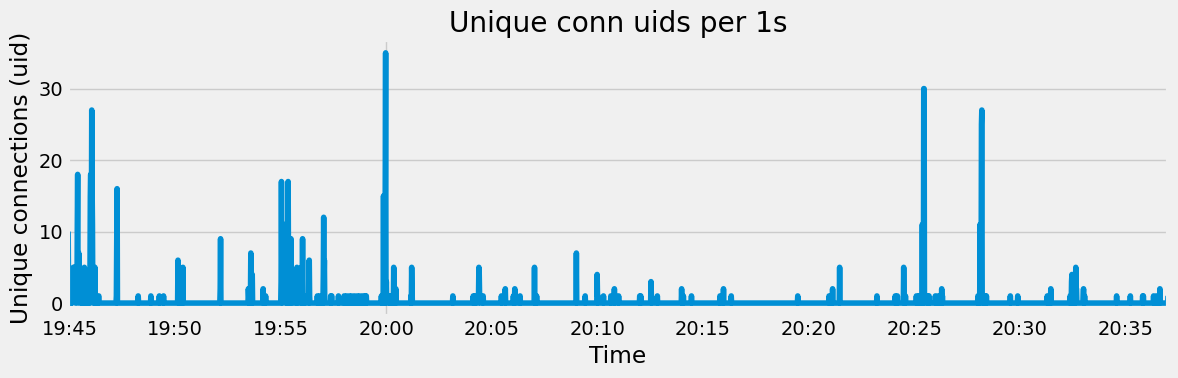

In [77]:
freq = "1s"

conn_unique = (
    df_conn.set_index("ts_dt")["uid"]
          .resample(freq)
          .nunique()
)

ax = conn_unique.plot(figsize=(12,4))
ax.set_xlabel("Time")
ax.set_ylabel("Unique connections (uid)")
ax.set_title(f"Unique conn uids per {freq}")
plt.tight_layout()
plt.show()


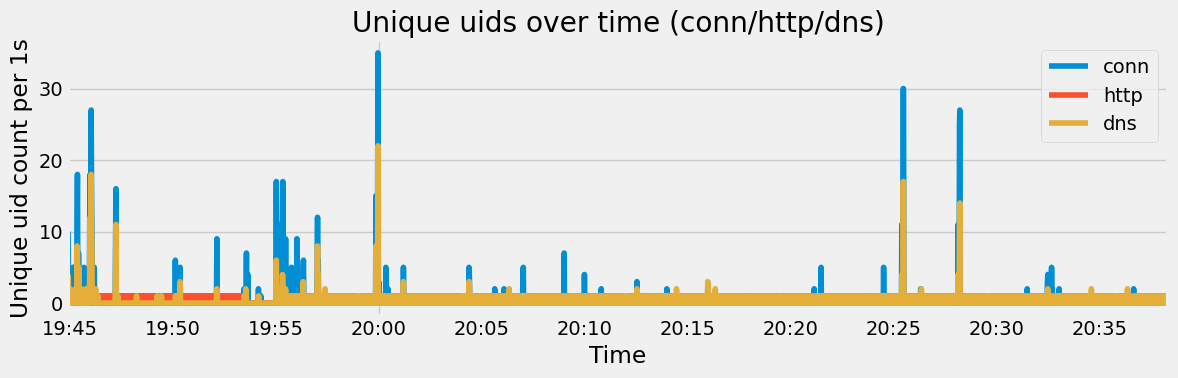

In [78]:
freq = "1s"

def series_count(df, name, unique_uid=False):
    s = df.set_index("ts_dt")["uid"].resample(freq)
    return (s.nunique() if unique_uid else s.size()).rename(name)

timeline = pd.concat(
    [
        series_count(df_conn, "conn", unique_uid=True),
        series_count(df_http, "http", unique_uid=True),
        series_count(df_dns,  "dns",  unique_uid=True),
    ],
    axis=1
).fillna(0).astype(int)

ax = timeline.plot(figsize=(12,4))
ax.set_xlabel("Time")
ax.set_ylabel(f"Unique uid count per {freq}")
ax.set_title("Unique uids over time (conn/http/dns)")
plt.tight_layout()
plt.show()

# (Optional) stacked view:
# timeline.plot.area(figsize=(12,4)); plt.tight_layout(); plt.show()
